In [ ]:
from glob import glob

%matplotlib inline
import os
from pathlib import Path
from IPython.display import Audio
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
!rm utils.py;wget https://raw.githubusercontent.com/sevenfx/fastai_audio/master/notebooks/utils.py
from utils import read_file, transform_path
from tqdm import tqdm

from IPython.display import clear_output

--2020-12-10 07:40:46--  https://raw.githubusercontent.com/sevenfx/fastai_audio/master/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7182 (7.0K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   7.01K  --.-KB/s    in 0s      

2020-12-10 07:40:46 (97.2 MB/s) - ‘utils.py’ saved [7182/7182]



In [1]:
Audio(fn)

NameError: ignored

In [ ]:
x, sr = read_file('audio.wav')
x.shape, sr, x.dtype

((51611, 2), 44100, dtype('float32'))

In [ ]:
def log_mel_spec_tfm(fname, src_path, dst_path):
    x, sample_rate = read_file(fname, src_path)

    n_fft = 1024
    hop_length = 256
    n_mels = 40
    fmin = 20
    fmax = sample_rate / 2
    
    mel_spec_power = librosa.feature.melspectrogram(x, sr=sample_rate, n_fft=n_fft, 
                                                    hop_length=hop_length, 
                                                    n_mels=n_mels, power=2.0, 
                                                    fmin=fmin, fmax=fmax)
    mel_spec_db = librosa.power_to_db(mel_spec_power, ref=np.max)
    dst_fname = dst_path / (fname + '.png')
    plt.imsave(dst_fname, mel_spec_db)

In [ ]:
log_mel_spec_tfm('audio.wav', '.', '.')
img = plt.imread('.png')
plt.imshow(img, origin='lower');

ParameterError: ignored

In [ ]:
transform_path(AUDIO_DIR, IMG_DIR, log_mel_spec_tfm, fnames=fnames, delete=True)

In [ ]:
os.listdir(str(IMG_DIR))[:10]

['pos_17.png',
 'pos_49.png',
 'pos_113.png',
 'neg_66.png',
 'neg_19.png',
 'neg_54.png',
 'neg_101.png',
 'neg_77.png',
 'pos_53.png',
 'neg_14.png']

In [ ]:
import fastai
fastai.__version__
from fastai.vision import *

In [ ]:
digit_pattern = r'(pos|neg)_\d{1,}\.png$'

In [ ]:
data = (ImageList.from_folder(IMG_DIR)
        .split_by_rand_pct(.2)
        .label_from_re(digit_pattern)
        .transform(size=(128,64))
        .databunch())
data.c, data.classes

(2, ['neg', 'pos'])

In [ ]:
xs, ys = data.one_batch()
xs.shape, ys.shape

(torch.Size([64, 3, 128, 64]), torch.Size([64]))

In [ ]:
xs.min(), xs.max(), xs.mean(), xs.std()

(tensor(0.0039), tensor(0.9894), tensor(0.2636), tensor(0.1888))

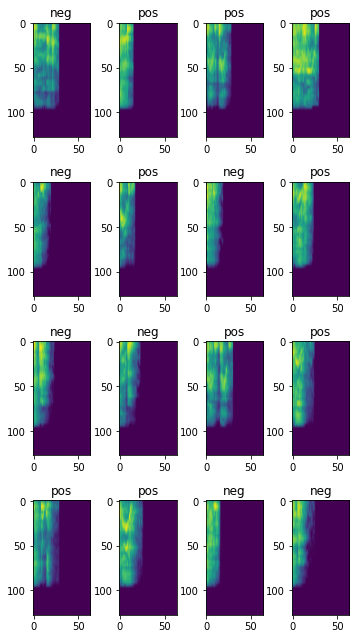

In [ ]:
data.show_batch(4, figsize=(5,9), hide_axis=False)

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.547210,0.883443,0.416667,00:03
1,1.469844,0.805949,0.458333,00:03
2,1.303680,0.817291,0.583333,00:03
3,1.144220,0.859908,0.458333,00:03
4,0.958060,0.998307,0.500000,00:03
5,0.843445,1.056394,0.458333,00:03
6,0.761737,1.068269,0.500000,00:03
7,0.674771,1.051574,0.500000,00:03
8,0.607029,1.097806,0.416667,00:03
9,0.554984,1.149099,0.458333,00:03


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.249388,1.177843,0.500000,00:04
1,0.175090,1.224558,0.583333,00:04
2,0.124639,1.337544,0.625000,00:04
3,0.110250,1.447169,0.625000,00:04
4,0.113830,1.247103,0.625000,00:04
5,0.106218,1.108350,0.666667,00:04
6,0.108776,1.080406,0.666667,00:04
7,0.099394,1.111811,0.583333,00:04
8,0.090747,0.989395,0.541667,00:04
9,0.081787,0.909471,0.541667,00:04


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

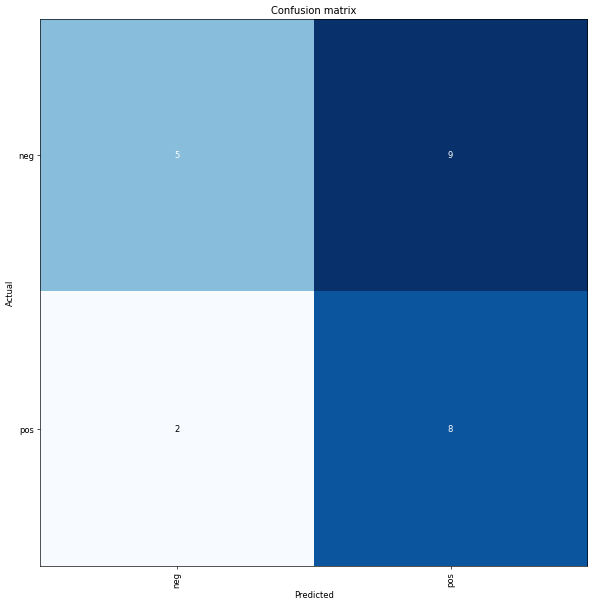

In [ ]:
interp.plot_confusion_matrix(figsize=(10, 10), dpi=60)

# Load and use Model

In [ ]:
learn.export('../export.pkl')

In [ ]:
learn = load_learner('')

In [ ]:
learn.predict(open_image('imgs/neg_0.png'))

(Category tensor(0), tensor(0), tensor([0.6724, 0.3276]))

In [ ]:
!mv covid/data/clinical/original/pos/* covid/data/clinical/original/;rm -rf covid/data/clinical/original/pos/
!mv covid/data/clinical/original/neg/* covid/data/clinical/original/;rm -rf covid/data/clinical/original/neg/

for ind, f in enumerate(tqdm(glob('covid/data/clinical/original/*'))):
  !ffmpeg -i {f} {'/'.join(f.split('/')[:4])+'/'+f.split('/')[-1].split('-')[0]+'_'+str(ind)+'.wav'} &>/dev/null
!rm covid/data/clinical/original/*.mp3

100%|██████████| 16/16 [00:02<00:00,  6.56it/s]


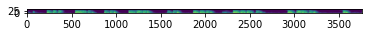

In [ ]:
fn = 'neg_6'
log_mel_spec_tfm(fn+'.wav', Path('covid/data/clinical/original'), IMG_DIR)
img = plt.imread(str(IMG_DIR/(fn + '.png')))
plt.imshow(img, origin='lower')

In [ ]:
learn.predict(open_image(IMG_DIR/(fn+'.png')))

(Category tensor(0), tensor(0), tensor([0.5770, 0.4230]))